# Case Study: Sentiment Analysis

### Setup

Import modules, read data

In [70]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
%matplotlib inline

sns.set()

# Read in the data
df = pd.read_csv('./data/reviews.csv')
# Sample the data to speed up computation
# Comment out this line to match with lecture

df.head(3)

,Unnamed: 0,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,394349,Sony XPERIA Z2 D6503 FACTORY UNLOCKED Internat...,NaN,244.95,5,Very good one! Better than Samsung S and iphon...,0.0
1,34377,Apple iPhone 5c 8GB (Pink) - Verizon Wireless,Apple,194.99,1,"The phone needed a SIM card, would have been n...",1.0
2,248521,Motorola Droid RAZR MAXX XT912 M Verizon Smart...,Motorola,174.99,5,I was 3 months away from my upgrade and my Str...,3.0


In [71]:
# Remove missing values
df.dropna(inplace=True)

# Drop reviews with neutral ratings
df = df[df['Rating'] != 3]

# Map ratings 4 and 5 to "positive" 
# Map ratings 1 and 2 to "negative"
df['Positively Rated'] = np.where(df['Rating'] > 3, 1, 0)
df.head(3)

,Unnamed: 0,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,Positively Rated
1,34377,Apple iPhone 5c 8GB (Pink) - Verizon Wireless,Apple,194.99,1,"The phone needed a SIM card, would have been n...",1.0,0
2,248521,Motorola Droid RAZR MAXX XT912 M Verizon Smart...,Motorola,174.99,5,I was 3 months away from my upgrade and my Str...,3.0,1
3,167661,CNPGD [U.S. Office Extended Warranty] Smartwat...,CNPGD,49.99,1,an experience i want to forget,0.0,0


In [72]:
# Most ratings are positive
df['Positively Rated'].mean()

0.7475328055525431

In [73]:

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df['Reviews'], 
                                                    df['Positively Rated'], 
                                                    random_state=0)

In [74]:
print('X_train first entry:\n\n', X_train.iloc[0])
print('\n\nX_train shape: ', X_train.shape)

X_train first entry:

 my daughter loves this phone,thanks


X_train shape:  (27663,)


# CountVectorizer

In [75]:

# Fit the CountVectorizer to the training data
vect = CountVectorizer().fit(X_train)

In [76]:
feature_names = vect.get_feature_names()
feature_names[::1000]
# vect.get_feature_names()[::2000]

['00',
 '8hrs',
 'anti',
 'biometric',
 'chao',
 'costco',
 'dinamico',
 'envió',
 'flicking',
 'guadalajara',
 'increment',
 'launch',
 'mgpx',
 'object',
 'phonen',
 'purposes',
 'responded',
 'sharing',
 'steffy',
 'thinn',
 'updating',
 'work4']

Number of features generated

In [77]:
len(vect.get_feature_names())

21344

In [78]:
# transform the documents in the training data to a document-term matrix
X_train_vectorized = vect.transform(X_train)
X_train_vectorized

<27663x21344 sparse matrix of type '<class 'numpy.int64'>'
	with 733003 stored elements in Compressed Sparse Row format>

In [79]:
# Train the model
logreg = LogisticRegression()
logreg.fit(X_train_vectorized, y_train)

/home/amarov/proj/presentation/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Compute the ROC curve and plot it. Compute the area under the ROC curve.

AUC:  0.89608861784919


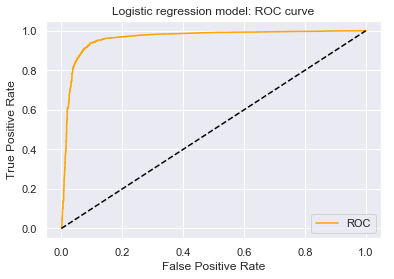

In [80]:
# Predict the transformed test documents
predictions = logreg.predict(vect.transform(X_test))
logreg_probs = logreg.predict_proba(vect.transform(X_test))
logreg_positive_probs = [p[1] for p in logreg_probs]

fpr, tpr, thresholds = roc_curve(y_test, logreg_positive_probs)

## Predicted probabilities from the logistic regression model
print('AUC: ', roc_auc_score(y_test, predictions))

def plot_roc(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='black', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Logistic regression model: ROC curve')
    plt.legend()
    plt.show()
    
plot_roc(fpr, tpr)

In [81]:
# get the feature names as numpy array
feature_names = np.array(vect.get_feature_names())

# Sort the coefficients from the model
sorted_coef_index = logreg.coef_[0].argsort()

# Find the 10 smallest and 10 largest coefficients
# The 10 largest coefficients are being indexed using [:-11:-1] 
# so the list returned is in order of largest to smallest
print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs:
['worst' 'terrible' 'waste' 'junk' 'sucks' 'horrible' 'broken' 'slow'
 'useless' 'poor']

Largest Coefs: 
['excelent' 'excelente' 'excellent' 'love' 'perfect' 'loves' 'perfectly'
 'great' 'amazing' 'wonderful']


# Tfidf

Fit another logistic regression model. This time vectorize using the DF-IDF vectorization.

In [82]:

# Fit the TfidfVectorizer to the training data specifiying a minimum document frequency of 5
idf_vect = TfidfVectorizer(min_df=5).fit(X_train)
len(idf_vect.get_feature_names())

5959

In [83]:
X_train_vectorized_idf = idf_vect.transform(X_train)

model = LogisticRegression()
model.fit(X_train_vectorized_idf, y_train)

predictions_idf = model.predict(idf_vect.transform(X_test))

roc_score = roc_auc_score(y_test, predictions_idf)
roc_score
    
print('AUC: ', roc_auc_score(y_test, predictions))

#roc_curve()

/home/amarov/proj/presentation/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC:  0.89608861784919


In [84]:
feature_names = np.array(vect.get_feature_names())

sorted_tfidf_index = X_train_vectorized.max(0).toarray()[0].argsort()

print('Smallest tfidf:\n{}\n'.format(feature_names[sorted_tfidf_index[:10]]))
print('Largest tfidf: \n{}'.format(feature_names[sorted_tfidf_index[:-11:-1]]))

Smallest tfidf:
['judicious' 'outsources' 'outsourced' 'outsource' 'outsmarts' 'outshines'
 'outshine' 'outstand' 'outset' 'outright']

Largest tfidf: 
['the' 'and' 'this' 'to' 'it' 'is' 'phone' 'you' 'iphone' 'for']


In [85]:
sorted_coef_index = model.coef_[0].argsort()

print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs:
['bummed' 'contacts' 'dials' 'ahhh' 'colors' 'afterwards' 'cuenta'
 'bugdroid' 'b01deyyd5g' 'descricion']

Largest Coefs: 
['attended' 'bloat' 'andissues' 'capturing' '4core' 'atd' 'antutu' 'chalk'
 '24am' '3845']


In [86]:
# These reviews are treated the same by our current model
print(model.predict(vect.transform(['not an issue, phone is working',
                                    'an issue, phone is not working'])))

ValueError: X has 21344 features per sample; expecting 5959

# n-grams

Fit a third logistic regression model using 

In [ ]:
# Fit the CountVectorizer to the training data specifiying a minimum 
# document frequency of 5 and extracting 1-grams and 2-grams
vect = CountVectorizer(min_df=5, ngram_range=(1,2)).fit(X_train)

X_train_vectorized = vect.transform(X_train)

len(vect.get_feature_names())

In [ ]:
model = LogisticRegression()
model.fit(X_train_vectorized, y_train)

predictions = model.predict(vect.transform(X_test))

print('AUC: ', roc_auc_score(y_test, predictions))

In [ ]:
feature_names = np.array(vect.get_feature_names())

sorted_coef_index = model.coef_[0].argsort()

print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

In [ ]:
# These reviews are now correctly identified
print(model.predict(vect.transform(['not an issue, phone is working',
                                    'an issue, phone is not working'])))